In [1]:
import numpy as np
import scipy
from scipy.integrate import quad, quad_vec
import matplotlib.pyplot as plt
from codes import utils
from functools import partial

In [2]:
def tb2kfunc(tb_model):
    """
    Fourier transforms a real-space tight-binding model to a k-space function.

    Parameters
    ----------
    tb_model : dict
        A dictionary with real-space vectors as keys and complex np.arrays as values.
    
    Returns
    -------
    function
        A function that takes a k-space vector and returns a complex np.array.
    """
    
    def bloch_ham(k):
        ham = 0
        for vector in tb_model.keys():
            ham += tb_model[vector] * np.exp(
                -1j * np.dot(k, np.array(vector, dtype=float))
            )
        return ham
    
    return bloch_ham


def kfunc2tbfunc(kfunc):
    """
    Inverse Fourier transforms a k-space function to a real-space function.

    Parameters
    ----------
    kfunc : function
        A function that takes a k-space vector and returns a np.array.

    Returns
    -------
    function
        A function that takes a real-space integer vector and returns a np.array.
    """
    def tbfunc(vector): 

        def integrand(k):
            return kfunc(k) * np.exp(1j * np.dot(k, np.array(vector, dtype=float)))
        
        return quad_vec(integrand, -np.pi, np.pi)[0]
    
    return tbfunc

In [3]:
def addTb(tb1, tb2):
    """
    Add up two tight-binding models together.

    Parameters:
    -----------
    tb1 : dict
        Tight-binding model.
    tb2 : dict
        Tight-binding model.
    
    Returns:
    --------
    dict
        Sum of the two tight-binding models.
    """
    return {k: tb1.get(k, 0) + tb2.get(k, 0) for k in frozenset(tb1) | frozenset(tb2)}

def generateRho(hkfunc, E_F):
    """
    Generate a function that returns the density matrix at a given k-point.

    Parameters
    ----------
    hkfunc : function
        Function that return Hamiltonian at a given k-point.
    E_F : float
        Fermi level

    Returns
    -------
    rho : function
        Density matrix at the same k-point as hk
    """
    def rhofunc(k):
        hk = hkfunc(k)
        vals, vecs = np.linalg.eigh(hk)
        unocc_vals = vals > E_F
        occ_vecs = vecs
        occ_vecs[:, unocc_vals] = 0

        # Outter products between eigenvectors
        return occ_vecs @ occ_vecs.T.conj()
    
    return rhofunc

def fermiOnGrid(hkfunc, filling, Nk=500):
    """
    Compute the Fermi energy on a grid of k-points.

    Parameters
    ----------
    hkfunc : function
        Function that returns the Hamiltonian at a given k-point.
    Nk : int
        Number of k-points in the grid.
    Returns
    -------
    E_F : float
        Fermi energy
    """

    ks = np.linspace(-np.pi, np.pi, Nk, endpoint=False)
    hkarray = np.array([hkfunc(k) for k in ks])
    vals = np.linalg.eigvalsh(hkarray)

    norbs = vals.shape[-1]
    vals_flat = np.sort(vals.flatten())
    ne = len(vals_flat)
    ifermi = int(round(ne * filling / norbs))
    if ifermi >= ne:
        return vals_flat[-1]
    elif ifermi == 0:
        return vals_flat[0]
    else:
        fermi = (vals_flat[ifermi - 1] + vals_flat[ifermi]) / 2
        return fermi

def totalEnergy(rho, hk):
    def integrand(k):
        return np.real(np.trace(rho(k) @ hk(k)))
    return quad(integrand, -np.pi, np.pi)[0]

def meanFieldTb(rhofunc, int_model):
    """
    Compute the mean-field in real space.

    Parameters
    ----------
    rhofunc : function
        Function that returns the density matrix at a given k-space vector.
    int_model : dict
        Interaction tb model.
    
    Returns
    -------
    dict
        Mean-field tb model.
    """
    rhoTbfunc = kfunc2tbfunc(rhofunc)

    # Compute direct interaction
    intZero = tb2kfunc(int_model)(0)
    direct = quad_vec(lambda k: np.diag(rhofunc(k)), -np.pi, np.pi)[0]
    direct = np.diag(direct @ intZero) / (2*np.pi)
    direct = {(0,) : direct}
    exchange = {vec: -1*(int_model.get(vec, 0)*rhoTbfunc(vec)) / (2*np.pi) for vec in frozenset(int_model)}
    return addTb(direct, exchange)

def matrix_to_flat(matrix):
    """
    Flatten the upper triangle of a collection of matrices.

    Parameters:
    -----------
    matrix : nd-array
        Array with shape (n, n)
    """
    return matrix[*np.triu_indices(matrix.shape[-1])].flatten()

def flat_to_matrix(flat, shape):
    """
    Undo `matrix_to_flat`.
    
    Parameters:
    -----------
    flat : 1d-array
        Output from `matrix_to_flat`.
    shape : 1d-array
        Shape of the input from `matrix_to_flat`.
    """
    matrix = np.zeros(shape, dtype=complex)
    matrix[*np.triu_indices(shape[-1])] = flat.reshape(*shape[:-2], -1)
    indices = np.arange(shape[-1])
    diagonal = matrix[indices, indices]
    matrix += np.moveaxis(matrix, -1, -2).conj()
    matrix[indices, indices] -= diagonal
    return matrix

def mf2rParams(mf_model):
    """
    Convert a mean-field tight-binding model to a set of real parameters.

    Parameters
    ----------
    mf_model : dict
        Mean-field tight-binding model.

    Returns
    -------
    dict
        Real parameters.
    """
    return utils.complex_to_real(matrix_to_flat(mf_model[(0,)])) # placeholder for now

def rParams2mf(rParams, shape):
    """
    Convert a set of real parameters to a mean-field tight-binding model.

    Parameters
    ----------
    r_params : dict
        Real parameters.
    shape : tuple
        Shape of the mean-field tight-binding model.

    Returns
    -------
    dict
        Mean-field tight-binding model.
    """
    return {(0,) : flat_to_matrix(utils.real_to_complex(rParams), shape)}

In [40]:
class Model:
    def __init__(self, tb_model, int_model, filling):
        self.tb_model = tb_model
        self.int_model = int_model
        self.filling = filling

    def densityMatrix(self, mf_model):
        self.hkfunc = tb2kfunc(addTb(self.tb_model, mf_model))
        self.calculateEF()
        return generateRho(self.hkfunc, self.EF)

    def calculateEF(self):
        self.EF = fermiOnGrid(self.hkfunc, self.filling)

    def mfield(self, mf_model):
        self.rhofunc = self.densityMatrix(mf_model)
        return addTb(meanFieldTb(self.rhofunc, self.int_model), {(0,): - self.EF * np.eye(4)})

In [42]:
def cost(rParams, Model):
    shape = Model.tb_model[(0,)].shape
    mf_model = rParams2mf(rParams, shape) # limited placeholder
    mf_new = Model.mfield(mf_model)
    rParamsNew = mf2rParams(mf_new)
    return rParamsNew - rParams

def solver(Model, x0, optimizer=scipy.optimize.anderson, optimizer_kwargs={}):
    rParams = mf2rParams(x0)
    f = partial(cost, Model=Model)
    result = rParams2mf(optimizer(f, rParams, **optimizer_kwargs), Model.tb_model[(0,)].shape)
    Model.calculateEF()
    return addTb(result, {(0,): - Model.EF * np.eye(4)})

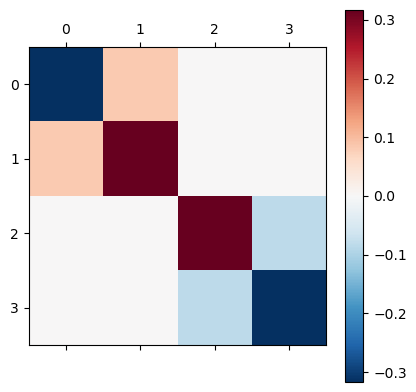

In [49]:
filling = 2

hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
tb_model = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}
mf_model = {(0,) : np.zeros((4,4))} # placeholder for guess

guess = np.random.rand(4, 4) * np.exp(1j * 2 * np.pi * np.random.rand(4, 4))
guess += guess.T.conj()
guess /= 2

mf_model = {(0,) : guess}

int_model = {
    (0,): 2 * np.kron(np.eye(2), np.ones((2, 2))),
}
tb = Model(tb_model, int_model, filling)
# np.diag(solver(tb, mf_model)[(0,)])
plt.matshow(solver(tb, mf_model)[(0,)].real, cmap='RdBu_r')
plt.colorbar()
plt.show()

In [48]:
# this is all wrong, because the mean-field is a diagonal constants term  :( 
def extractOnsite(U0):
    int_model = {
        (0,): U0 * np.kron(np.eye(2), np.ones((2, 2))),
    }
    tb = Model(tb_model, int_model, filling)
    return np.abs(solver(tb, mf_model)[(0,)])[0, 0]

Us = np.linspace(0, 2, 10)
plt.plot(Us, [extractOnsite(U) for U in Us])

KeyboardInterrupt: 